In [ ]:
import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from scipy.io import loadmat                    # To load .mat files
from pylab import *  
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF
from pandas import DataFrame as df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Background**

Spike trains are best described as *point processes*, a time-series of binary events occurring continuously in time. Some examples of point processes include: heart beats, earthquakes, and geiser eruptions. Event occurrences are associated to an underlying continuous process that evolves over time. For geyser events, the continuous process is changes in water pressure. For earthquakes, it's changes in pressure between the tectonic plates. For spike rates, the continuous process is fluctuations in the membrane voltage.

A point process can be characterized solely by its *conditional intensity function*, $\lambda(t|H_t)$ (Daley and Vere-Jones, 2003), which is defined as

$$\lambda(t|H_t) = lim_{\Delta t \rightarrow \infty} \frac{Pr(\Delta N_{(t,t+\Delta t]} = 1 | H_t)}{\Delta t}$$

Here, $Pr(\Delta N_{(t,t+\Delta t]} = 1 | H_t)$ is the instantaneous probability of a spike in a small time window, conditioned on history $H_t$, up to time t. All probabilities are non-negative, so the conditional intensity function is positive. It also defines the complete probability model for the point process. It is also a stochastic process because it depends on history, which is a stochastic process in itself. 

In this notebook, I simulated a conditional intensity function using an auto-regressive model of order 1, meaning that the values of the conditional intensity function at time $k$ depend only on the values of the conditional intensity function at time $k-1$. 

$$ x_t = \rho \cdot x_{t-1} + \alpha \cdot I_t + \sigma^2_t $$

$$ \lambda(t|x_t) = \frac{\exp(\mu + \beta \cdot x_t)}{1 + \exp(\mu + \beta \cdot x_t)}$$

The parameter $\alpha$ determines how much a stimulus $I_t$ affects the probability of spiking, where $I_t$ takes value 1 if there is a stimulus at time $t$, and 0 otherwise. Similarly, $\rho$ governs the amount by which $x_{t-1}$ affects the value of $x_t$. $\sigma^2_t$ is a common source of 0 mean gaussian noise, with covariance matrix $\Sigma$ (so noise is correlated across time). Additionally, $\mu$ is the background firing rate in Hz, and $\beta$ determines how much $x_t$ affects the rate, relative to the background firing rate. To obtain the conditional intensity function, I applied the logistic transform, to constrain values between 0 and 1. 

This approach was adapted from Smith and Brown (2003). 

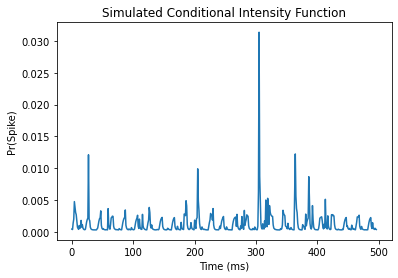

In [ ]:
mu = -5.9 #background firing rate
rho= 0.5
a  = 2
T  = 0.5 #length of timeseries in seconds
FS = 1/1000 # sampling rate (Hz)
NT = int(T/FS) #number of samples
beta = 0.5
# stimulus component
I = np.zeros((20,))
I[5:10] = 1
I = np.tile(I,int(NT/10))
A = np.random.beta(0.1,1,NT)
A = np.reshape(A,(-1,1))
A = (A + A.T)/2
A = np.matmul(A, A.T)
MU= np.zeros((NT,))
SE= np.random.multivariate_normal(MU, A, size=None, check_valid='warn', tol=1e-8)# latent model definition

x = np.zeros((NT,))
lam=np.zeros((NT,))
x[0] = rho + a * I[1] + SE[0]
lam[0] = np.exp(mu + beta * x[0])
for k in range(1,NT-1):
    x[k] = (rho * x[k-1]) + (a * I[k]) + SE[k]
    lam[k]=np.exp(mu + beta * x[k])/(1+np.exp(mu + beta * x[k]))

plt.plot(lam[2:NT-1])
plt.ylabel('Pr(Spike)')
plt.xlabel('Time (ms)')
plt.title('Simulated Conditional Intensity Function')
plt.show()


In [ ]:
np.shape(A)

(500, 500)

Once we have our conditional intensity function, we can simulate spike times by using the Time Rescaling Theorem. Briefly, the time rescaling theorem states that the inter-spike intervals are independent and identically distributed exponential random variables with mean 1. 
$$ \tau_t = \int_{u_{t-1}}^{u_t}\lambda(t|H_t)dt $$

$$ \tau_t \sim \exp(1) $$

Using numerical integration ``np.trapz()``, we can find the next spike time by simulating an exponential random variable with mean 1 and solving the equation.

In [ ]:
spike_times = [];
u_km1 = 0;
u_k = 0;
tau = -np.log( np.random.uniform(0,1,1) )
icif= np.trapz(lam[u_km1:u_k])
while u_k < NT-1:
    while (icif < tau) and (u_k < NT-1):
        u_k = u_k + 1
        icif = np.trapz(lam[u_km1:u_k])
    spike_times.append(u_k)
    u_km1 = u_k
    tau = -np.log( np.random.uniform(0,1,1) )


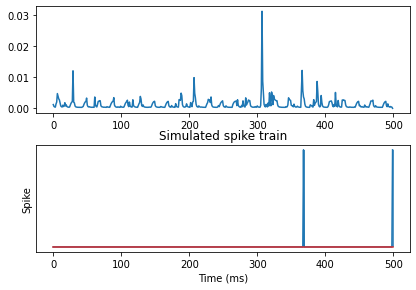

In [ ]:
n_spikes = len(lam)
spikes = np.zeros((n_spikes,))
spikes[spike_times]=1
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplot(211)
plt.plot(lam)
plt.subplot(212)
plt.stem(spikes,markerfmt='',use_line_collection=True)
plt.ylabel('Spike')
plt.xlabel('Time (ms)')
plt.title('Simulated spike train')
plt.yticks([])
plt.show()

To-do:

1. Using the code above for simulating a spike train via Time Rescaling, simulate 10 more spike trains and store each of them in a matrix (or a list of lists).
2. Plot each spike train like the figure above, with each spike train in an individual row.
3. How similar or different are these spike trains, and why?

Reading materials

**Simulating a conditional intensity function:**
Smith, A.C. and Brown, E.N., 2003. Estimating a state-space model from point process observations. Neural computation, 15(5), pp.965-991.

**The Time Rescaling Theorem**
Brown, E.N., Barbieri, R., Ventura, V., Kass, R.E. and Frank, L.M., 2002. The time-rescaling theorem and its application to neural spike train data analysis. Neural computation, 14(2), pp.325-346.

**Uri Eden's Point Process Notes**
http://www.stat.columbia.edu/~liam/teaching/neurostat-fall17/uri-eden-point-process-notes.pdf

In [ ]:
def spike_stim():
  spike_times = [];
  u_km1 = 0;
  u_k = 0;
  tau = -np.log( np.random.uniform(0,1,1) )
  icif= np.trapz(lam[u_km1:u_k])
  while u_k < NT-1:
      while (icif < tau) and (u_k < NT-1):
          u_k = u_k + 1
          icif = np.trapz(lam[u_km1:u_k])
      spike_times.append(u_k)
      u_km1 = u_k
      tau = -np.log( np.random.uniform(0,1,1) )
  n_spikes = len(lam)
  spikes = np.zeros((n_spikes,))
  spikes[spike_times]=1
  return spikes

In [ ]:
spike_matrix = []
for i in range(10):
  spike_matrix.append(spike_stim())
  print(i)


0
1
2
3
4
5
6
7
8
9


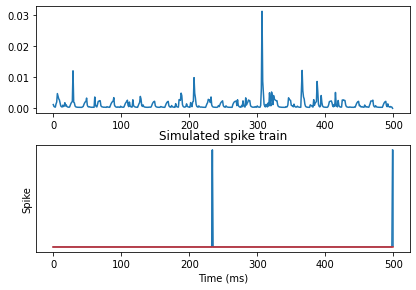

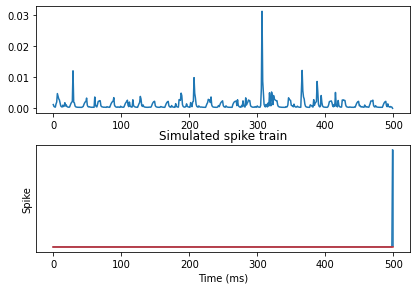

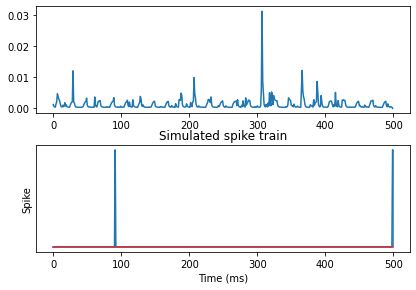

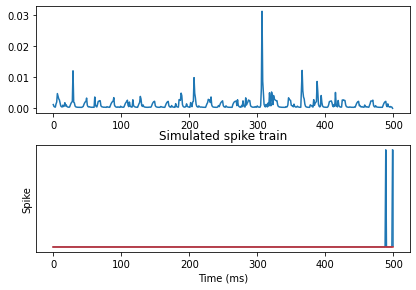

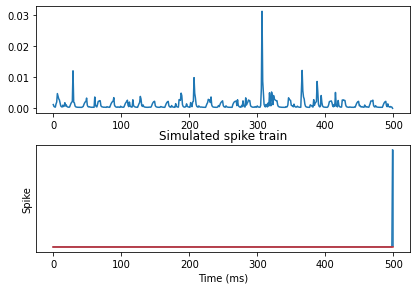

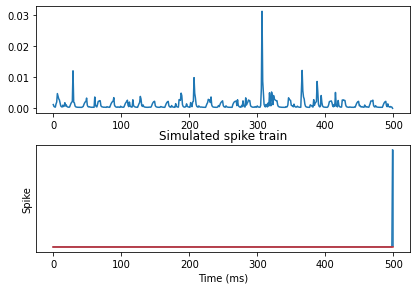

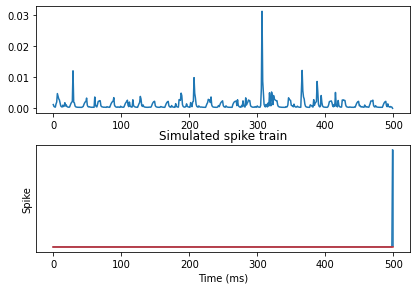

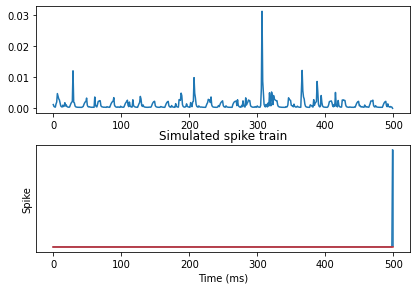

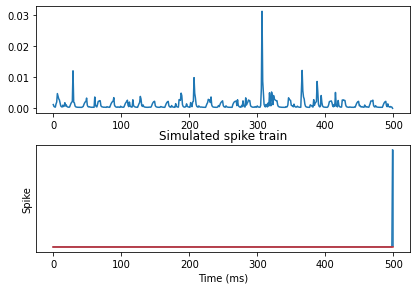

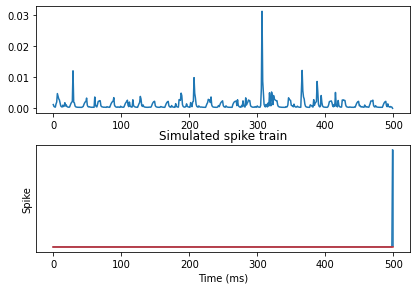

In [ ]:
for j in range(10):
  fig, axes = plt.subplots(nrows=2, ncols=1)
  fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
  plt.subplot(211)
  plt.plot(lam)
  plt.subplot(212)
  plt.stem(np.array(spike_matrix[j]),markerfmt='',use_line_collection=True)
  plt.ylabel('Spike')
  plt.xlabel('Time (ms)')
  plt.title('Simulated spike train')
  plt.yticks([])
  plt.show()

Fairly similar, because you're sampling from the same distribution. The differences are due to the stochasticity in the sampling process


In [ ]:
#from textbook
rcParams['figure.figsize']=(12,3) 

In [ ]:
np.random.rand(1)[0]

0.6559468029406266

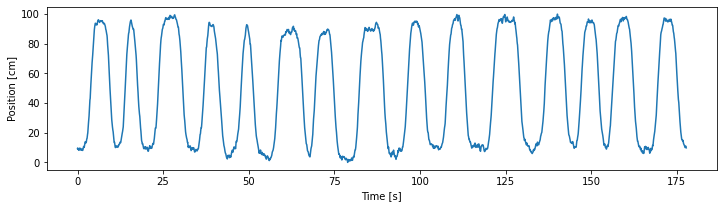

In [ ]:
data = loadmat('spikes-1.mat')  # Load the data,
t = data['t'][:,0]              # Extract the t variable,
X = data['X'][:,0]              # Extract the X variable,
plot(t, X)                      # ... and plot it.
xlabel('Time [s]')
ylabel('Position [cm]')
show()

In [ ]:
# t = list(range(500))           # Extract the t variable,
# X = spike_matrix[0] 
# plot(t,X)                     # ... and plot it.
# xlabel('Time [s]')
# ylabel('Position [cm]')
# show()

In [ ]:
spiketimes = data['spiketimes']
n_bins = len(t)
# Histogram spikes into bins centered at times t:
spiketrain = histogram(spiketimes, 
                         bins = n_bins, 
                         range = (t[0], t[-1]))[0] 

In [ ]:
predictors = df(data={'Intercept': ones_like(X), 'X': X})

# GLM model with Poisson family and identity link function
model2 = sm.GLM(spiketrain, predictors, family=Poisson())  # GLM model with Poisson family, omitting link function
model2_results = model2.fit()  # Fit model to our data
b2 = model2_results.params     # Get the predicted coefficient vector
print(b2)

Intercept   -7.438887
X            0.012943
dtype: float64


In [ ]:
# Fit Model 3 to the spike train data (omitting last input).
predictors['X2'] = X**2       # Add column for X^2

# GLM model with Poisson family and identity link function
model3 = sm.GLM(spiketrain, predictors, family=Poisson())
model3_results = model3.fit() # Fit model to our data
b3 = model3_results.params    # Get the predicted coefficient vector
print('b3:\n', b3)

b3:
 Intercept   -26.279057
X             0.690114
X2           -0.005463
dtype: float64


In [ ]:
LL3 = model3.loglike(b3)
AIC3 = -2 * LL3 + 2 * 3
print('AIC3: ', AIC3)

AIC3:  2708.7763622920465


In [ ]:
from numpy import linalg as LA

In [ ]:
def mu(x, beta):
  return exp(np.transpose(beta).dot(x))/(1+np.transpose(beta).dot(x))

In [ ]:
def y(x,beta,error):
  return mu(x,beta) + error

In [ ]:
#logistic regression maximum likelihood estimate w/iteratively reweighted least squares:

def irls(inputs, p):
  #initial guess for beta
  
  #number of observations:
  beta = np.random.rand(p)
  i = 0
  weight_diff = 1
  weights = [1]*len(inputs)
  z = [0]*len(inputs)
  #loop
  while weight_diff > 10**(-10):
    
    for j in range(len(inputs)):
      mu_j = mu(x[j],beta)
      weights[j] = mu_j*(1-mu_j)
    W = diag(weights)
    for j in range(len(inputs)):
      mu_j = mu(x[j],beta)
      y_j = np.array(x[j]).dot(W)
      z[j] = np.transpose(beta)*x[j] + (y_j - mu_j)/mu_j*(1-mu_j)
    beta_plus = np.divide(np.transpose(inputs)*W*z, np.transpose(inputs)*W*inputs)
    weight_diff = LA.norm(beta_plus-beta)
    beta = beta_plus
    i += 1
  return(beta,weights)
 

In [ ]:
#irls(spike_matrix[0],500)

In [ ]:
#irls(spike_matrix[0],10)
inputs= spike_matrix[0]
np.shape(inputs)
# inputs are jx1 where j = 500

(500,)

In [ ]:
#let p = 20
p=500
beta = np.random.rand(p)
beta

array([0.96223113, 0.26941056, 0.33728341, 0.42729151, 0.79907593,
       0.03067744, 0.28989386, 0.44985296, 0.56820627, 0.61406615,
       0.37130969, 0.90479769, 0.32726039, 0.18415497, 0.01439417,
       0.54977611, 0.81663057, 0.47768919, 0.13908209, 0.68690889,
       0.21517499, 0.03698588, 0.07019199, 0.96985508, 0.52245967,
       0.03826309, 0.23485755, 0.72184607, 0.38375551, 0.12487072,
       0.97139919, 0.52732169, 0.96929792, 0.23665936, 0.56233436,
       0.34471303, 0.78580036, 0.19281586, 0.1008029 , 0.29932068,
       0.86327503, 0.69710099, 0.84956847, 0.40962698, 0.42912512,
       0.8546731 , 0.46300824, 0.60766483, 0.74993944, 0.03997832,
       0.09247041, 0.31978434, 0.48108494, 0.65392273, 0.61603024,
       0.66980103, 0.23530586, 0.38516092, 0.150928  , 0.2788604 ,
       0.0180202 , 0.35541892, 0.15650143, 0.90114815, 0.59382051,
       0.88671722, 0.93216629, 0.05445365, 0.35409254, 0.62573349,
       0.42599454, 0.45650085, 0.58910471, 0.03704383, 0.46403

In [ ]:
weight_diff = 1
weights = [1]*len(inputs)
z = [0]*len(inputs)


In [ ]:
mu_ = mu(x,beta)
mu_

-1.31014789417546e-255

In [ ]:
for j in range(len(inputs)):
      weights[j] = mu_[j]*(1-mu_[j])